In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install ucimlrepo

In [4]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# metadata
print(heart_disease.metadata)

# variable information
print(heart_disease.variables)


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M. Pfisterer, J. Schmid, S. Sa

In [5]:
heart_disease.data.targets.value_counts()

num
0      164
1       55
2       36
3       35
4       13
Name: count, dtype: int64

In [6]:
X.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [7]:
df=pd.concat([X, y], axis=1)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [8]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
num           int64
dtype: object

In [9]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64

In [10]:
df=df.fillna(df.mean())
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

In [11]:
df['num'].unique()

array([0, 2, 1, 3, 4])

In [12]:
df['num'].unique()

array([0, 2, 1, 3, 4])

**Train test split**

In [13]:
X = df.drop('num',axis='columns')
y = df['num']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [14]:
def monitor_class_distribution(y):
  class_distribution = np.bincount(y)
  if class_distribution[1]>class_distribution[0]:
    imbalance_ratio = class_distribution[1] / class_distribution[0]
  else:
    imbalance_ratio = class_distribution[0] / class_distribution[1]
  return imbalance_ratio

In [15]:
imb_ratio=monitor_class_distribution(y)
print(imb_ratio)

2.981818181818182


before applying sampling

In [16]:
import time
import psutil
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve


def train_resource_monitor(X_train, y_train):
  model= xgb.XGBClassifier(
      objective='binary:logistic',
      max_depth=3,
      learning_rate=0.1,
      n_estimators=100,
      subsample=0.8,
      colsample_bytree=0.8
  )
  cpu_usage = []
  memory_usage = []
  initial_cpu_percent = psutil.cpu_percent(interval=None)
  initial_memory_percent = psutil.virtual_memory().percent
  start_time = time.time()
  model.fit(X_train, y_train)
  end_time = time.time()
  execution_time = end_time - start_time
  final_cpu_percent = psutil.cpu_percent(interval=None)
  final_memory_percent = psutil.virtual_memory().percent
  size=len(y_train)
  print(f"Input size: {size}, Execution time: {execution_time:.6f} seconds")
  print(f"Initial CPU Usage: {initial_cpu_percent}%")
  print(f"Final CPU Usage: {final_cpu_percent}%")
  print(f"Initial Memory Usage: {initial_memory_percent}%")
  print(f"Final Memory Usage: {final_memory_percent}%")
  return model

In [17]:
model1=train_resource_monitor(X_train, y_train)

Input size: 242, Execution time: 0.337325 seconds
Initial CPU Usage: 80.4%
Final CPU Usage: 100.0%
Initial Memory Usage: 9.3%
Final Memory Usage: 9.4%


In [18]:
from sklearn.model_selection import KFold

def k_fold_validation_1(X_train, y_train,model):
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    cv_scores = []
    #cv_rocs = []
    lb = LabelBinarizer()  # Initialize LabelBinarizer outside the loop
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred_val = model.predict(X_val_fold)

        # Transform validation fold labels using the fitted LabelBinarizer
        #y_true_binarized = lb.fit_transform(y_val_fold)

        # Predict probabilities for the validation fold
        #y_prob_roc = model.predict_proba(X_val_fold)

        # Compute accuracy
        accuracy = accuracy_score(y_val_fold, y_pred_val)
        cv_scores.append(accuracy)

        # Compute ROC-AUC
        #roc_auc_scores = roc_auc_score(y_true_binarized, y_prob_roc, average=None)
        #avg_roc_auc = roc_auc_scores.mean()
        #cv_rocs.append(avg_roc_auc)

        print("Cross-validation scores:", cv_scores)
        print("Average cross-validation score:", np.mean(cv_scores))
        #print("Cross-validation roc-auc:", avg_roc_auc)
        #print("Average cross-validation roc-auc:", np.mean(cv_rocs))
        print('-----------------------------------------------------------------')

In [19]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def k_fold_validation(X_train, y_train,model):
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    cv_scores = []
    cv_rocs = []
    lb = LabelBinarizer()  # Initialize LabelBinarizer outside the loop
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred_val = model.predict(X_val_fold)

        # Transform validation fold labels using the fitted LabelBinarizer
        y_true_binarized = lb.fit_transform(y_val_fold)

        # Predict probabilities for the validation fold
        y_prob_roc = model.predict_proba(X_val_fold)

        # Compute accuracy
        accuracy = accuracy_score(y_val_fold, y_pred_val)
        cv_scores.append(accuracy)

        # Compute ROC-AUC
        roc_auc_scores = roc_auc_score(y_true_binarized, y_prob_roc, average=None)
        avg_roc_auc = roc_auc_scores.mean()
        cv_rocs.append(avg_roc_auc)

        print("Cross-validation scores:", cv_scores)
        print("Average cross-validation score:", np.mean(cv_scores))
        print("Cross-validation roc-auc:", avg_roc_auc)
        print("Average cross-validation roc-auc:", np.mean(cv_rocs))
        print('-----------------------------------------------------------------')

In [20]:
k_fold_validation_1(X_train, y_train,model1)


Cross-validation scores: [0.5714285714285714]
Average cross-validation score: 0.5714285714285714
-----------------------------------------------------------------
Cross-validation scores: [0.5714285714285714, 0.5306122448979592]
Average cross-validation score: 0.5510204081632653
-----------------------------------------------------------------
Cross-validation scores: [0.5714285714285714, 0.5306122448979592, 0.5208333333333334]
Average cross-validation score: 0.5409580498866213
-----------------------------------------------------------------
Cross-validation scores: [0.5714285714285714, 0.5306122448979592, 0.5208333333333334, 0.5625]
Average cross-validation score: 0.546343537414966
-----------------------------------------------------------------
Cross-validation scores: [0.5714285714285714, 0.5306122448979592, 0.5208333333333334, 0.5625, 0.6458333333333334]
Average cross-validation score: 0.5662414965986395
-----------------------------------------------------------------


In [21]:
# Making predictions
y_pred = model1.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5901639344262295


In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

y_prob = model1.predict_proba(X_test)
# Binarize the true labels
lb = LabelBinarizer()
y_true_binarized = lb.fit_transform(y_test)

# Calculate ROC-AUC for each class
roc_auc_scores = roc_auc_score(y_true_binarized, y_prob, average=None)

# Average the ROC-AUC scores across all classes
avg_roc_auc = roc_auc_scores.mean()

print("ROC-AUC scores for each class:", roc_auc_scores)
print("Average ROC-AUC score:", avg_roc_auc)


ROC-AUC scores for each class: [0.90692641 0.57818182 0.86243386 0.77248677 0.84482759]
Average ROC-AUC score: 0.7929712892471514


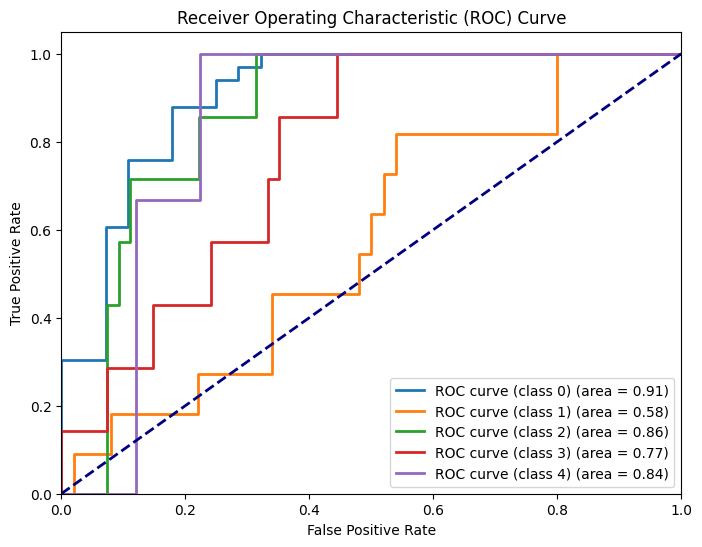

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Generate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=5
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class {}) (area = {:0.2f})'.format(i, roc_auc[i]))

# Plot random guessing line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [24]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.97      0.86        33
           1       0.20      0.09      0.13        11
           2       0.20      0.14      0.17         7
           3       0.20      0.29      0.24         7
           4       0.00      0.00      0.00         3

    accuracy                           0.59        61
   macro avg       0.28      0.30      0.28        61
weighted avg       0.50      0.59      0.54        61



applying sampling

In [25]:
X2 = df.drop('num',axis='columns')
y2 = df['num']

In [26]:
print(X2.dtypes)

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
dtype: object


In [27]:
X2.shape, y2.shape

((303, 13), (303,))

In [28]:
y2.value_counts()

num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

In [29]:
df.columns[:-1].tolist()

['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal']

In [86]:
import pandas as pd
from imblearn.over_sampling import KMeansSMOTE
from imblearn.under_sampling import ClusterCentroids

def adjust_sampling_parameters(X,y):
  # Apply KMeansSMOTE to the minority class
  #kmeans_smote = KMeansSMOTE(sampling_strategy={0: 164, 1: 55, 2: 36, 3: 35, 4: 13}, k_neighbors=15, cluster_balance_threshold=0.2)
  kmeans_smote = KMeansSMOTE(sampling_strategy='auto', k_neighbors=3, cluster_balance_threshold=0.1,random_state=42)
  X_kmeans_smote, y_kmeans_smote = kmeans_smote.fit_resample(X, y)

  # Apply Cluster Centroids undersampling to the majority class
  #cluster_centroids = ClusterCentroids(sampling_strategy={0: 159, 1: 50, 2: 31, 3: 30, 4: 8})
  cluster_centroids = ClusterCentroids(sampling_strategy='auto')
  X_cluster_centroids, y_cluster_centroids = cluster_centroids.fit_resample(X, y)

  # Concatenate the resampled data
  X_combined_resampled = np.concatenate((X_kmeans_smote, X_cluster_centroids), axis=0)
  y_combined_resampled = np.concatenate((y_kmeans_smote, y_cluster_centroids), axis=0)

  # Convert combined resampled data to DataFrame
  combined_df = pd.DataFrame(data=X_combined_resampled, columns=X.columns.tolist())
  combined_df['Class'] = y_combined_resampled
  return combined_df



In [87]:
tolerance=0.2
def class_distribution_check(combined_df):
  X_combined = combined_df.drop('Class',axis='columns')
  y_combined = combined_df['Class']
  class_distribution=monitor_class_distribution(y_combined)
  while abs(class_distribution-1)>tolerance:
    #print(abs(class_distribution-1))
    combine_data=adjust_sampling_parameters(X_combined, y_combined)
    X_combined=combine_data.drop('Class',axis='columns')
    y_combined=combine_data['Class']
    class_distribution=monitor_class_distribution(y_combined)
  return X_combined, y_combined

In [88]:
combined_df=adjust_sampling_parameters(X2,y2)
X_combined,y_combined=class_distribution_check(combined_df)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

In [89]:
print((X_combined.shape))

(890, 13)


In [90]:
model2=train_resource_monitor(X_train, y_train)

Input size: 712, Execution time: 0.481285 seconds
Initial CPU Usage: 27.3%
Final CPU Usage: 100.0%
Initial Memory Usage: 11.8%
Final Memory Usage: 11.8%


In [91]:
k_fold_validation(X_combined, y_combined,model2)

Cross-validation scores: [0.8258426966292135]
Average cross-validation score: 0.8258426966292135
Cross-validation roc-auc: 0.9631781215897343
Average cross-validation roc-auc: 0.9631781215897343
-----------------------------------------------------------------
Cross-validation scores: [0.8258426966292135, 0.8876404494382022]
Average cross-validation score: 0.8567415730337078
Cross-validation roc-auc: 0.9757968485973603
Average cross-validation roc-auc: 0.9694874850935473
-----------------------------------------------------------------
Cross-validation scores: [0.8258426966292135, 0.8876404494382022, 0.8370786516853933]
Average cross-validation score: 0.850187265917603
Cross-validation roc-auc: 0.9594153495455849
Average cross-validation roc-auc: 0.9661301065775598
-----------------------------------------------------------------
Cross-validation scores: [0.8258426966292135, 0.8876404494382022, 0.8370786516853933, 0.8820224719101124]
Average cross-validation score: 0.8581460674157303
C

In [92]:
# Making predictions
y_pred = model2.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.949438202247191


In [93]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

y_prob = model2.predict_proba(X_test)
# Binarize the true labels
lb = LabelBinarizer()
y_true_binarized = lb.fit_transform(y_test)

# Calculate ROC-AUC for each class
roc_auc_scores = roc_auc_score(y_true_binarized, y_prob, average=None)

# Average the ROC-AUC scores across all classes
avg_roc_auc = roc_auc_scores.mean()

print("ROC-AUC scores for each class:", roc_auc_scores)
print("Average ROC-AUC score:", avg_roc_auc)

ROC-AUC scores for each class: [0.9966034  0.99473684 0.99755639 0.99906015 1.        ]
Average ROC-AUC score: 0.9975913560124086


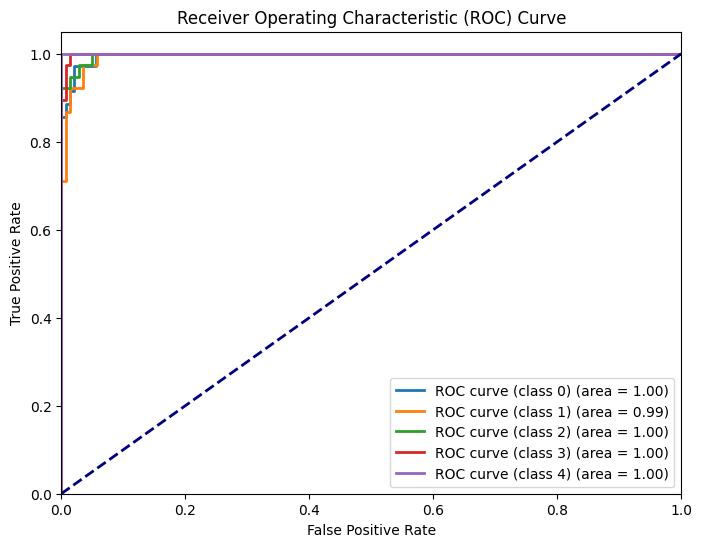

In [94]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Generate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=5
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class {}) (area = {:0.2f})'.format(i, roc_auc[i]))

# Plot random guessing line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [95]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        35
           1       0.92      0.89      0.91        38
           2       0.97      0.95      0.96        38
           3       0.95      0.97      0.96        38
           4       1.00      1.00      1.00        29

    accuracy                           0.95       178
   macro avg       0.95      0.95      0.95       178
weighted avg       0.95      0.95      0.95       178



In [96]:
import pickle

# Assuming you have trained an XGBoost model named 'model'

# Save the model to a file
with open('xgboost_model_cleve.pkl', 'wb') as f:
    pickle.dump(model2, f)

In [97]:
import pickle

# Load the model from the file
with open('xgboost_model_cleve.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [98]:
predictions = loaded_model.predict(X_test)

In [99]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        35
           1       0.92      0.89      0.91        38
           2       0.97      0.95      0.96        38
           3       0.95      0.97      0.96        38
           4       1.00      1.00      1.00        29

    accuracy                           0.95       178
   macro avg       0.95      0.95      0.95       178
weighted avg       0.95      0.95      0.95       178

